In [2]:
import pandas as pd
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
import statsmodels.discrete.discrete_model as sm

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 5

In [3]:
url = 'https://raw.githubusercontent.com/Jneny/Hospitalcapacity/main/Data/icu_beds.csv'
data = read_csv(url, header=0, parse_dates=[0], index_col=0)
data = data.asfreq('d')
adultcrit = pd.DataFrame(data, columns=['adult_icu_crci_patients'])
sadultcrit = pd.Series(adultcrit.adult_icu_crci_patients)

We will be training the model with a train/test split of 80%/20%

In [4]:
size = int(len(adultcrit)*.8)
adtrain = adultcrit.iloc[:size]
adtest = adultcrit.iloc[size:]

In [5]:
#Check stationarity of train set - not stationary
adfuller(adtrain) 

(-2.2612806643894445,
 0.18475986084292328,
 17,
 506,
 {'1%': -3.443339692005083,
  '5%': -2.8672689011327894,
  '10%': -2.569821287318971},
 3345.276584636624)

The two methods of making the data stationary was tested, one by differencing before modelling, auto arima was actually ARMA since d = 1 was pre-processed
1. Differencing first then using auto arima -> gave (1,0,1) ARMA, AIC = 3489.560
2. Directly using auto arima with train set -> gave (1,1,1) ARIMA of integration 1, AIC = 3487.595
The second method results had a slightly higher AIC score so directly using auto arima on train was the better method by 1.965.

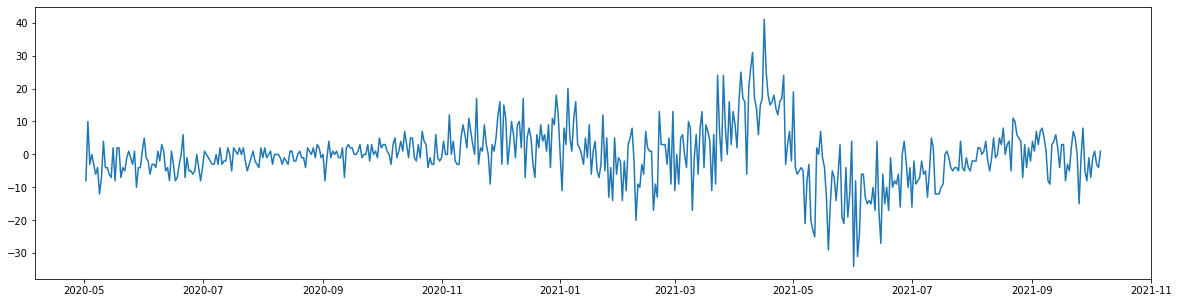

In [8]:
adcdiff = adtrain.adult_icu_crci_patients.diff()
plt.plot(adcdiff)

In [9]:
adfuller(adcdiff.dropna())
#is now stationary pvalue  0.020

(-3.1950096069661607,
 0.020275366078131147,
 16,
 506,
 {'1%': -3.443339692005083,
  '5%': -2.8672689011327894,
  '10%': -2.569821287318971},
 3342.9429689854946)

In [10]:
#Finding order for arima
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [11]:
#show step-by-step as auto arima finds best values for (p,d,q)
stepwise_fit = auto_arima(adcdiff[1:], trace = True, supress_warnings = True)
stepwise_fit.summary

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3493.197, Time=0.39 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=3727.426, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=3598.877, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=3649.944, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3725.635, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3491.550, Time=0.27 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=3604.875, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=3489.560, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=3491.551, Time=0.16 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=3553.783, Time=0.09 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3487.594, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3648.094, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3596.963, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3489.584, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]          

<function pmdarima.arima.arima.ARIMA.summary(self)>

In [12]:
#use the found order in the actual arima on train data
import statsmodels.api as sm

In [19]:
model = sm.tsa.arima.ARIMA(adcdiff[1:], order = (1,0,1))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     adult_icu_crci_patients   No. Observations:                  523
Model:                      ARIMA(1, 0, 1)   Log Likelihood               -1740.780
Date:                     Mon, 07 Mar 2022   AIC                           3489.560
Time:                             23:31:20   BIC                           3506.599
Sample:                         05-02-2020   HQIC                          3496.233
                              - 10-06-2021                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3850      2.105     -0.183      0.855      -4.511       3.741
ar.L1          0.9741      0.010    101.113      0.000       0.955       0.993
ma.L1         -0.8059      0.024    -33.769      0.000      -0.853      -0.759
sigma2        45.4760      2.089     21.774      0.000      41.383      49.569
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                73.79
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               5.60   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Check fit of model on train

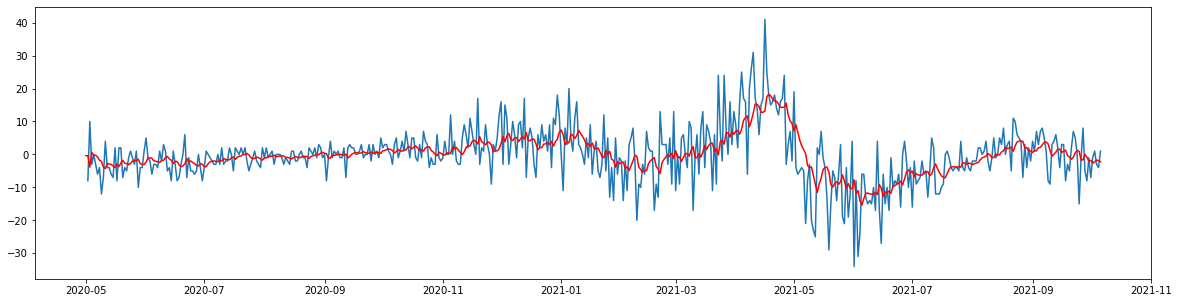

In [14]:
plt.plot(adcdiff)
plt.plot(result.fittedvalues, color = 'red')

Method # 2 directly using arima on train

In [22]:
stepwise_fit_whole = auto_arima(adtrain, trace = True, supress_warnings = True)
stepwise_fit_whole.summary

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3493.198, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3727.426, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3598.878, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3649.945, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3725.635, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3491.551, Time=0.28 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3604.875, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3489.561, Time=0.12 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3491.551, Time=0.18 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3553.783, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=3487.595, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3648.096, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=3596.964, Time=0.02 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=3489.585, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0]          

<function pmdarima.arima.arima.ARIMA.summary(self)>

Shows order (1,1,1) same order as method 1 but the differencing will be automatically done

In [23]:
model_whole = sm.tsa.arima.ARIMA(adtrain, order = (1,1,1))
result_whole = model_whole.fit()
result_whole.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  SARIMAX Results                                  
===================================================================================
Dep. Variable:     adult_icu_crci_patients   No. Observations:                  524
Model:                      ARIMA(1, 1, 1)   Log Likelihood               -1740.798
Date:                     Mon, 07 Mar 2022   AIC                           3487.595
Time:                             23:33:39   BIC                           3500.374
Sample:                         05-01-2020   HQIC                          3492.600
                              - 10-06-2021                                         
Covariance Type:                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9741      0.010    101.754      0.000       0.955       0.993
ma.L1         -0.8058      0.024    -34.252      0.000      -0.852      -0.760
sigma2        45.4794      2.085     21.813      0.000      41.393      49.566
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                73.67
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               5.60   Skew:                            -0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

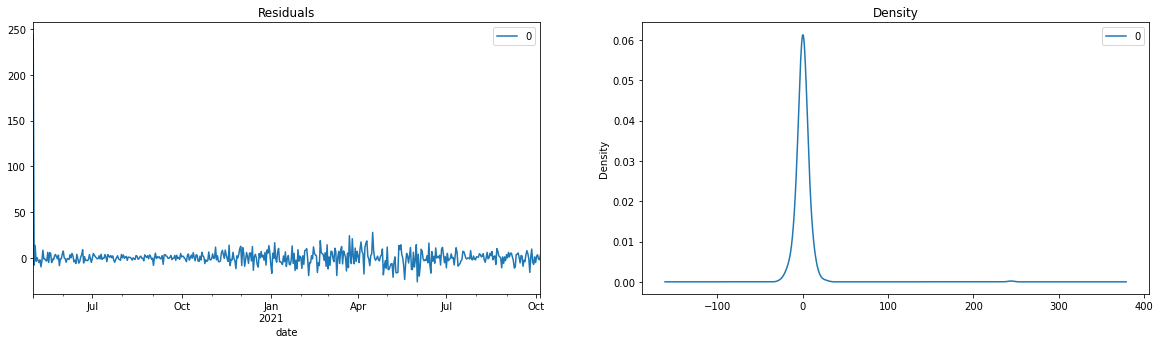

In [24]:
#Examine for 0 mean and variance
residuals = pd.DataFrame(result_whole.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

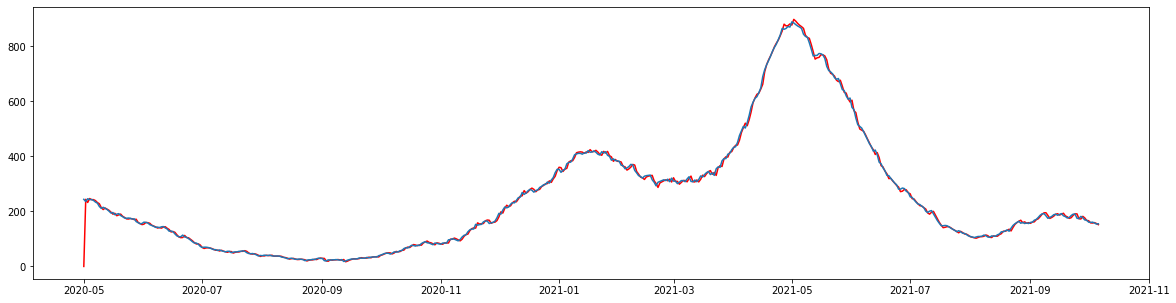

In [29]:
# Actual vs Fitted
act_and_fitt = result_whole.predict(dynamic=False)
plt.plot(act_and_fitt, color = 'red')
plt.plot(adtrain)

In [47]:
sadtest = pd.Series(adtest.adult_icu_crci_patients, copy = True)

AttributeError: 'Series' object has no attribute 'ret_ftse'

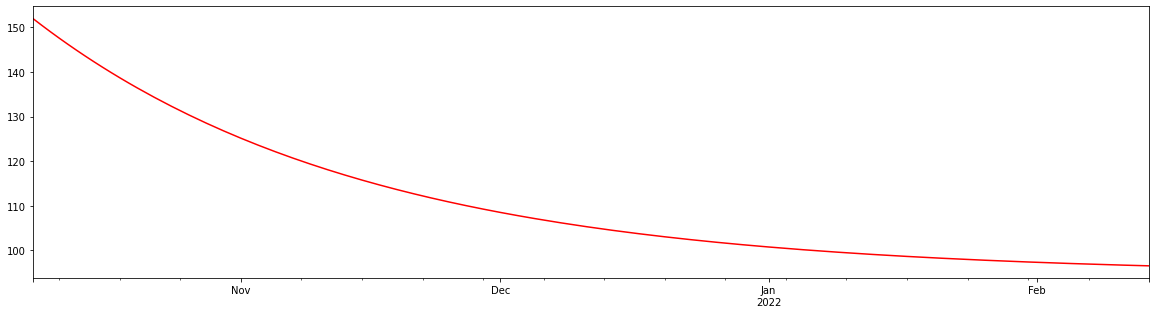

In [48]:
start = len(adtrain)
end = len(adtrain) + len(adtest) -1
start_date = "2020-05-02"
end_date = "2021-10-06"
end_test = "2022-02-14"

start

whole_pred_arima = result_whole.predict(start = start_date, end = end_test)
whole_pred_arima[start:end].plot(color = 'red')
sadtest.ret_ftse[start:end].plot(color = 'blue')

In [37]:
adtest.tail()

,adult_icu_crci_patients
date,
2022-02-10,442
2022-02-11,429
2022-02-12,407
2022-02-13,395
2022-02-14,386


In [31]:

result_whole

# Forecast
fc, se, conf = result_whole.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=adtest.index)
lower_series = pd.Series(conf[:, 0], index=adtest.index)
upper_series = pd.Series(conf[:, 1], index=adtest.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: too many values to unpack (expected 3)